# Work in progress (WIP)

# 6. Shor's algorithm

In this lesson you will learn:
- Exponential speedups in quantum computing
- Phase estimation
- The Quantum Fourier Transform (QFT)
- Shor's algorithm for integer factorization


# Work in progress (WIP)

In [1]:
# Kaleido is used to convert Plotly to static png
!pip install -Uqq kaleido
# skq is used to construct and convert quantum circuits
!pip install -Uqq skq

In [2]:
import numpy as np

from skq.utils import matrix_heatmap
from skq.circuits import Concat, Circuit
from skq.gates.qubit import I, H, CS, CT, SWAP, QFT, CU, QubitGate

# Fix Plotly rendering in Jupyter forks.
# If you are running this notebook locally you can comment this out.
# This allows you to play with interactive Plotly plots.
import plotly.io as pio
pio.renderers.default = 'png'

## Quantum Fourier Transform

- **Quantum Fourier Transform (QFT)**. The matrix for QFT is the same as the normal discrete Fourier transform, because this matrix is already unitary. When we use it we still call it Quantum Fourier Transform to clarify that we are using it in a quantum context. The QFT can be computed at cost $O(n^2)$ time.

QFT for 1 qubit (2 dimensions) is the same as the Hadamard gate:

$$QFT_2 = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix} = H$$

QFT for 2 qubits (4 dimensions):

$$QFT_4 = \frac{1}{2} \begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & i & -1 & -i \\
1 & -1 & 1 & -1 \\
1 & -i & -1 & i
\end{bmatrix}$$

QFT for $N$ qubits:

$$QFT_N = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} e^{2\pi i \frac{xy}{N}} |x\rangle\langle y|$$

Custom QFT circuit

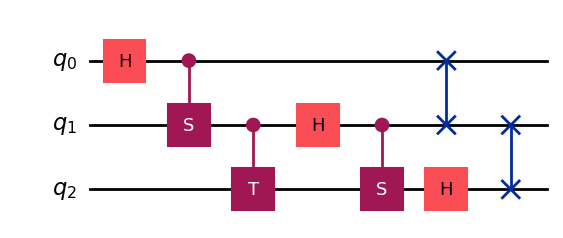

In [3]:
qft_3_circuit = Circuit(
    [
        Concat([H(), I(), I()]),
        Concat([CS(), I()]),
        Concat([I(), CT()]),
        Concat([I(), H(), I()]),
        Concat([I(), CS()]),
        Concat([I(), I(), H()]),
        Concat([SWAP(), I()]),
        Concat([I(), SWAP()])
    ]
)
qft_3_circuit.draw(output='mpl')


In [4]:
qft_3_circuit([0, 0, 0, 0, 1, 0, 0, 0])

H([ 0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
    0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j])

QFT

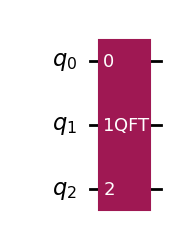

In [5]:
qft_3_skq = QFT(n_qubits=3, inverse=False)
qft_3_skq.draw(output='mpl')

In [6]:
qft_3_skq([0, 0, 0, 0, 1, 0, 0, 0])

array([ 0.35355339+0.00000000e+00j, -0.35355339+1.57009246e-16j,
        0.35355339-3.14018492e-16j, -0.35355339+4.71027738e-16j,
        0.35355339-6.28036983e-16j, -0.35355339+7.85046229e-16j,
        0.35355339-9.42055475e-16j, -0.35355339+1.09906472e-15j])

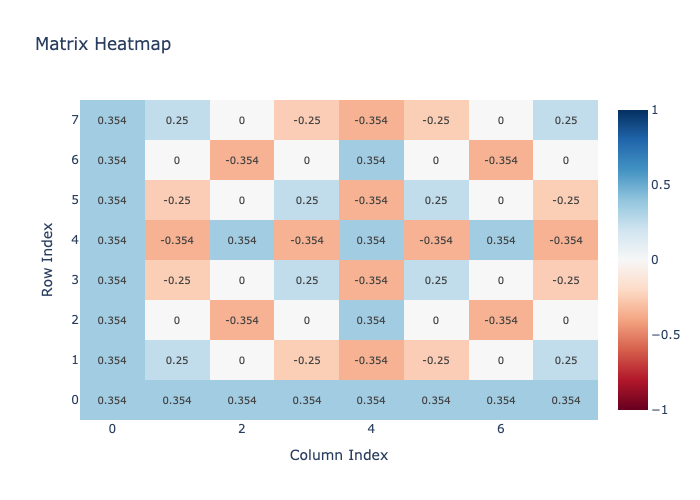

In [7]:
matrix_heatmap(qft_3_skq.__array__())

Inverse QFT

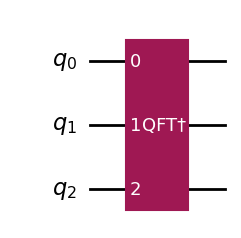

In [8]:
qft_3_dagger = QFT(n_qubits=3, inverse=True)
qft_3_dagger.draw(output='mpl')

In [9]:
qft_3_dagger([0, 0, 0, 0, 1, 0, 0, 0])

array([ 0.35355339+0.00000000e+00j, -0.35355339-1.57009246e-16j,
        0.35355339+3.14018492e-16j, -0.35355339-4.71027738e-16j,
        0.35355339+6.28036983e-16j, -0.35355339-7.85046229e-16j,
        0.35355339+9.42055475e-16j, -0.35355339-1.09906472e-15j])

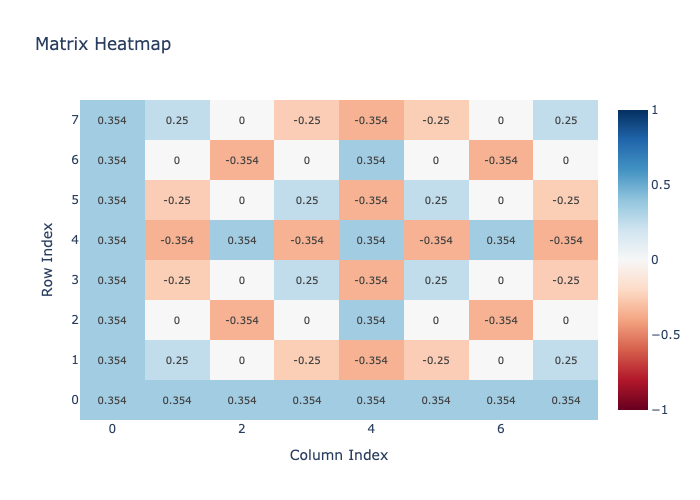

In [10]:
matrix_heatmap(qft_3_dagger.__array__())

## Quantum Phase Estimation

Controlled unitaries

In [11]:
def mod_mult_matrix(a, N) -> QubitGate:
    """
    Simple modular multiplication matrix: |y⟩ → |a*y mod N⟩
    :param a: base (coprime to N)
    :param N: Number to factor
    :return: QubitGate
    """
    # Calculate required number of qubits
    n_qubits = np.ceil(np.log2(N))
    
    dim = int(2**n_qubits)
    matrix = np.zeros((dim, dim), dtype=complex)
    
    # Fill in the modular multiplication mapping
    for y in range(N):
        result = (a * y) % N
        matrix[result, y] = 1.0
    
    # Identity operation for states outside computational space
    for y in range(N, dim):
        matrix[y, y] = 1.0
        
    return QubitGate(matrix)

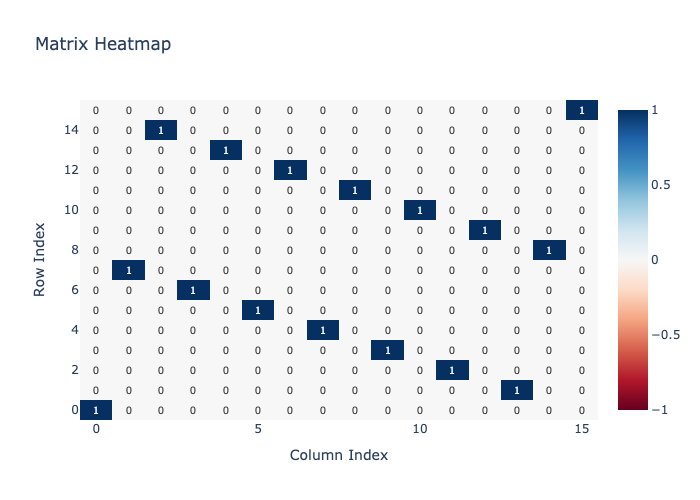

In [12]:
mod_matrix = mod_mult_matrix(a=7, N=15)
matrix_heatmap(mod_matrix)

No to_qiskit defined for 'QubitGate'. Initializing as UnitaryGate.


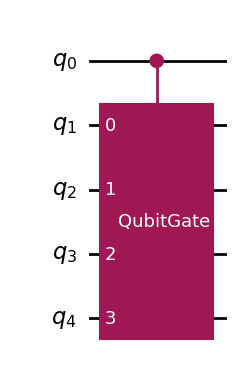

In [13]:
U = mod_mult_matrix(7, 15)
controlled_U = CU(U)
controlled_U.draw(output='mpl')

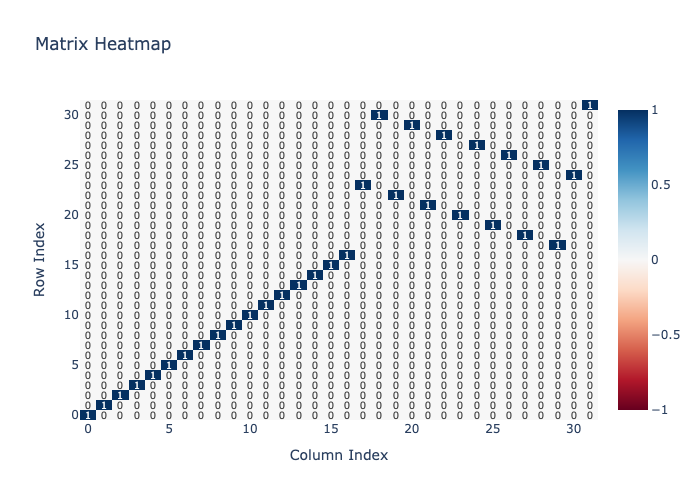

In [14]:
matrix_heatmap(controlled_U)

In [15]:
controlled_ops = []
for j in range(4):
    power = 2**j
    U_power = QubitGate(np.linalg.matrix_power(U, power)) 
    controlled_ops.append(CU(U_power))

No to_qiskit defined for 'QubitGate'. Initializing as UnitaryGate.
No to_qiskit defined for 'QubitGate'. Initializing as UnitaryGate.
No to_qiskit defined for 'QubitGate'. Initializing as UnitaryGate.
No to_qiskit defined for 'QubitGate'. Initializing as UnitaryGate.


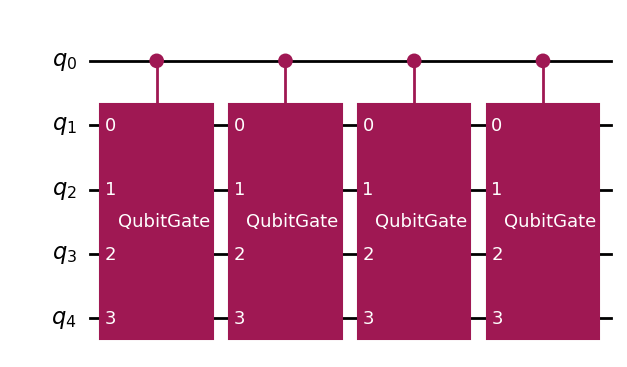

In [16]:
c = Circuit(controlled_ops)
c.draw(output='mpl')

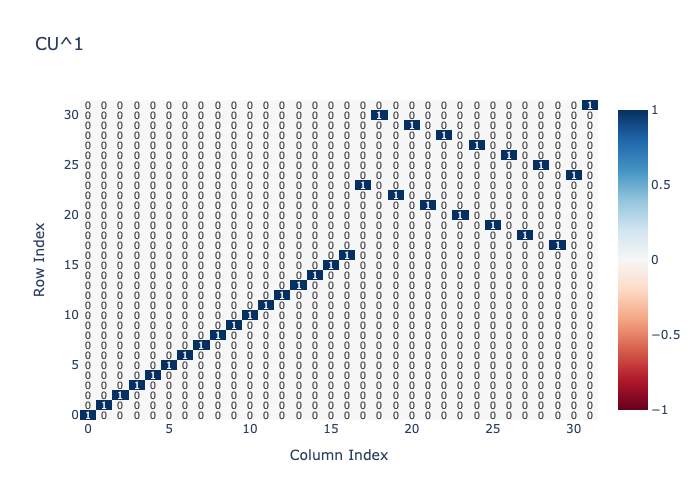

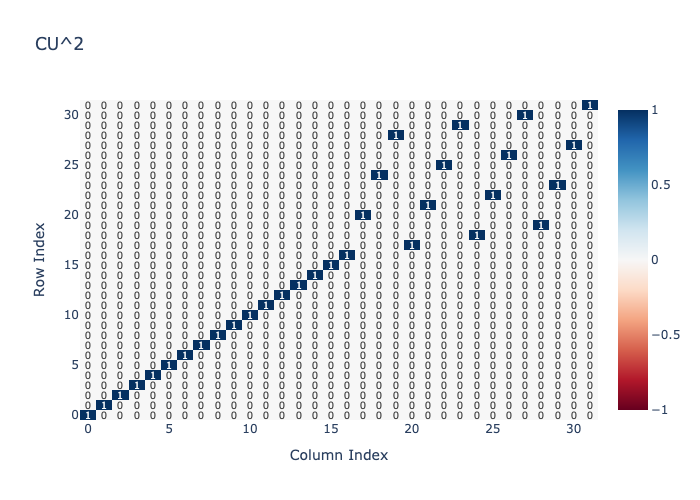

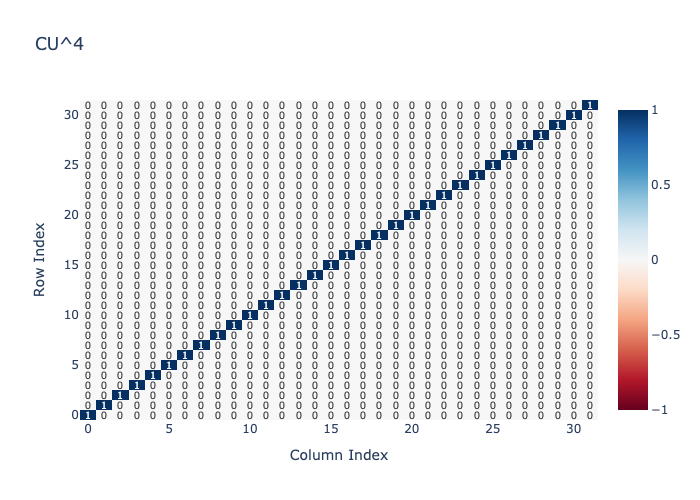

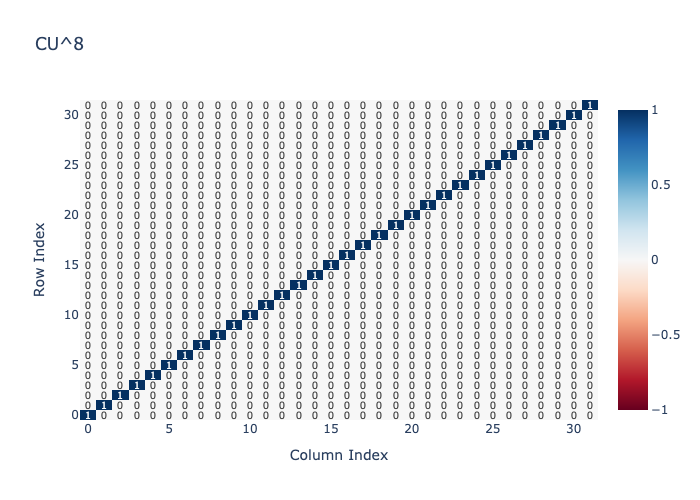

In [17]:
for i, op in enumerate(controlled_ops):
    matrix_heatmap(op, title=f'CU^{2**i}').show()

## Shor's algorithm

- The holy grail of quantum algorithms, demonstrated to give an exponential speedup over classical algorithms in factoring integers.

- Leverages the idea of Simon's algorithm to factor integers.
- First consider subproblem of order-finding is solved using **Phase estimation**. If we can find an efficient algorithm for this, then we can also find an efficient algorithm for integer factorization.


Total cost of Shor's algorithm is $O(n^3)$. This is because the controlled unitary operations have cost $O(n^3)$.




# Work in progress (WIP)